<a href="https://colab.research.google.com/github/nicolaiberk/llm_ws/blob/main/notebooks/04a_tokens_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers: Contextualized Embeddings, Tokenization, and Inference

In [ ]:
!pip install torch
!pip install transformers datasets evaluate accelerate
!pip install torch

### REMEMBER TO RESTART HERE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Contextual Embeddings

This notebook provides a hands-on introduction to three fundamental concepts in modern NLP:
1. **Simple Attention Mechanism** - Understanding how context changes word meaning
2. **Subword Tokenization** - How text is broken down for neural models
3. **Hugging Face Pipelines** - Quick inference with pre-trained models

## 1. Simple Attention Mechanism

### Understanding the Problem

The word "flies" has different meanings in these sentences:
- "Fruit flies like bananas" - *flies* = insects
- "Time flies like an arrow" - *flies* = moves quickly

Let's see how attention helps disambiguate this!

### Setup and Get Word Embeddings

We start with some example word vectors.

In [ ]:
## word embeddings for the sentences above
embeddings = {
    'fruit': np.array([0.8, 0.2, 0.1, 0.3]),
    'flies': np.array([0.5, 0.5, 0.6, 0.3]),
    'like': np.array([0.3, 0.7, 0.4, 0.5]),
    'bananas': np.array([0.9, 0.1, 0.2, 0.4]),
    'time': np.array([0.1, 0.3, 0.8, 0.7]),
    'an': np.array([0.2, 0.4, 0.3, 0.1]),
    'arrow': np.array([0.2, 0.4, 0.9, 0.8]),
    # Related words for comparison
    'insects': np.array([0.7, 0.3, 0.2, 0.1]),
    'bugs': np.array([0.6, 0.4, 0.3, 0.2]),
    'soars': np.array([0.3, 0.8, 0.7, 0.9]),
    'glides': np.array([0.2, 0.7, 0.8, 0.8])
}

In [ ]:
# reduce dimensionality to 2 and plot selected word embeddings

## dimensionality reduction using PCA
# reduce dimensionality to 2 and plot selected word embeddings

## dimensionality reduction using PCA
interesting_words = ['fruit', 'flies', 'bananas', 'insects', 'bugs', 'soars', 'glides', 'arrow']
interesting_vecs = np.array([embeddings[w] for w in interesting_words])
pca = PCA(n_components=2)
wv_2d = pca.fit_transform(interesting_vecs)
wv_2d = pd.DataFrame(wv_2d, index=interesting_words)


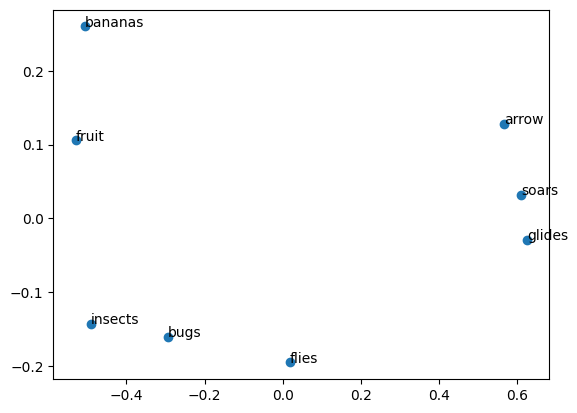

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(wv_2d[0], wv_2d[1])

for i in wv_2d.index:
    plt.annotate(i, (wv_2d[0][i], wv_2d[1][i]))

plt.show()

## Calculate Attention

For each sentence, we take the dot product of the vector for 'flies' against all others, ensure that the weights sum to 1, multiply with the initial vector, and plot the result. What can you observe?

In [ ]:
## calculate attention weights
sentence_a = ["time", "flies", "like", "an", "arrow"]
sentence_b = ["fruit", "flies", "like", "bananas"]

scores_a = pd.DataFrame(columns=sentence_a)
scores_b = pd.DataFrame(columns=sentence_b)

query = embeddings['flies']

for key in sentence_a:
    score = np.dot(embeddings[key], query)
    scores_a.at['flies', key] = score

for key in sentence_b:
    score = np.dot(embeddings[key], query)
    scores_b.at['flies', key] = score

In [ ]:
scores_a

,time,flies,like,an,arrow
flies,0.89,0.95,0.89,0.51,1.08


In [ ]:
scores_a = scores_a.astype(float).values.flatten() ## make list of values
scores_b = scores_b.astype(float).values.flatten()

In [ ]:
from scipy.special import softmax
# Normalize scores to sum to 1 using softmax
norm_scores_a = softmax(scores_a)
norm_scores_b = softmax(scores_b)

In [ ]:
norm_scores_a

array([0.20181848, 0.21429824, 0.20181848, 0.13801587, 0.24404892])

In [ ]:
sum(norm_scores_a) ## double-check

0.9999999999999999

In [ ]:
## Calculate Contextualized Vector
context_vector_a = np.dot(norm_scores_a, np.array([embeddings[context] for context in sentence_a]))
context_vector_b = np.dot(norm_scores_b, np.array([embeddings[context] for context in sentence_b]))

In [ ]:
new_vecs = np.append(interesting_vecs, [context_vector_a, context_vector_b], axis=0)

In [ ]:
pca = PCA(n_components=2)
wv_2d = pca.fit_transform(new_vecs)
wv_2d = pd.DataFrame(wv_2d, index=interesting_words + ["'flies' (A)", "'flies' (B)"])

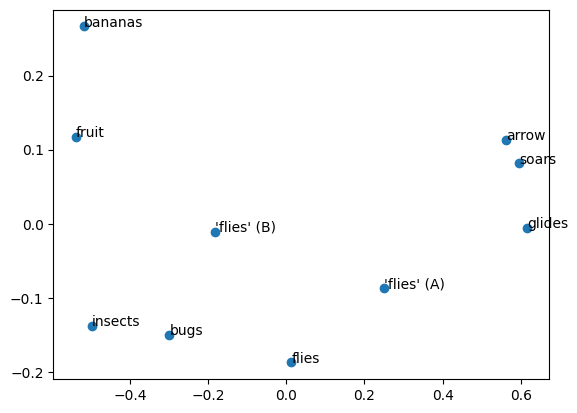

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(wv_2d[0], wv_2d[1])

for i in wv_2d.index:
    plt.annotate(i, (wv_2d[0][i], wv_2d[1][i]))

plt.show()

Note that this would not look that great with high-dimensional vectors used in transformers. The large dot products resulting from these vectors create issues. Transformers therefore uses a scaled dot product and learn a weight matrix to learn the query, key, and value vectors.

## Tokenization for Transformers

In this part of the tutorial, we are going to explore tokenization in the Huggingface Transformers framework.

The simplest way to access a tokenizer using the transformers library is the `AutoTokenizer` class. This class automatically provides the right tokenizer for a corresponding model.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

You can encode any input using the tokenizer you just created. It will return a dictionary with three values for each token.

In [ ]:
encoded_input = tokenizer("Use the GPU!")
print(encoded_input)

{'input_ids': [101, 11696, 1103, 15175, 2591, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


The `input_ids` provide the ID for a given token. The `attention_mask` indicates which tokens should be attended to. In this case, all tokens are attended to, so the attention mask is all ones. By setting some to zero, you can tell the tokenizer to ignore specific tokens. The `token_type_ids` can be safely ignored for our purposes today (if you are very eager, you can learn more [here](https://huggingface.co/docs/transformers/main/en/glossary#token-type-ids)).

You can see that there are plenty more IDs (7) than words (3). Why might that be?

In [ ]:
len(encoded_input['input_ids'])

7

You can assess the tokenization using the `tokenize` method...

In [ ]:
tokenizer.tokenize("Use the GPU!")

['Use', 'the', 'GP', '##U', '!']

...and map the IDs back to actual text using the `decode` method.

In [ ]:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] Your model is much faster on the GPU [SEP]'

Can you remember the use of the [CLS] and [SEP] tokens?

Let's compare this output to another tokenizer, `bert-base-uncased`:

In [ ]:
uncased_tknzr = AutoTokenizer.from_pretrained("bert-base-uncased")
encoded_input = uncased_tknzr("Transformers rule!")
print(uncased_tknzr.decode(encoded_input["input_ids"]))

[CLS] transformers rule! [SEP]


You can also use the method to encode multiple texts:

In [ ]:
batch_sentences = [
    'What about second breakfast?',
    "Don't think he knows about second breakfast, Pip.",
    'What about elevensies?'
]
tokenizer(batch_sentences)

{'input_ids': [[101, 1327, 1164, 1248, 6462, 136, 102], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}

Note that you can also explicitly ask for padding tokens in the encoding of batches. This will lead to speed-ups when processing batches (you usually don't have to take care of this yourself).

In [ ]:
tokenizer(batch_sentences, padding=True)

{'input_ids': [[101, 1327, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [ ]:
tokenizer.decode([101, 1327, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0])

'[CLS] What about second breakfast? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

Similarly, you can ask for truncation to shorten texts which might be longer than the maximum input of your model:

In [ ]:
tokenizer(batch_sentences, padding=True, truncation=True, max_length=10)

{'input_ids': [[101, 1327, 1164, 1248, 6462, 136, 102, 0, 0, 0], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 102], [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]}

The Huggingface library provides the tokenizers alongside the transformer models so you use the right transformer for each model. You can find an extensive explanation of tokenizers [here](https://github.com/huggingface/notebooks/blob/main/transformers_doc/en/tokenizer_summary.ipynb).

## First Inference with Transformers

The fastest way to run inference is the pipeline function:

In [ ]:
from transformers import pipeline
feature_extractor = pipeline('feature-extraction', model='bert-base-cased', tokenizer='bert-base-cased')

/Users/niberk/Dropbox (Personal)/Teaching/LLM_WS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


In [ ]:
features = feature_extractor("Transformers are great for NLP tasks!")
len(features[0])

10

In [ ]:
len(features[0][0])  # Length of the feature vector for each token

768

In [ ]:
## You can simply call for a different task and the pipeline will replace the classification head
classifier = pipeline('sentiment-analysis', model='bert-base-cased', tokenizer='bert-base-cased')
classifier("Transformers are great for NLP tasks!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


[{'label': 'LABEL_0', 'score': 0.6436623334884644}]

Particularly useful is zero-shot classification:

In [ ]:
from transformers import pipeline

classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-base-zeroshot-v2.0",
    tokenizer="MoritzLaurer/deberta-v3-base-zeroshot-v2.0"
)

classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

/Users/niberk/Dropbox (Personal)/Teaching/LLM_WS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


{'sequence': 'This is a course about the Transformers library',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.9973854422569275, 0.0023361321073025465, 0.0002784667885862291]}

In [ ]:
emotions = classifier(
    ["I just cant do this anymore...", "I HATE this!", "Transformers are amazing!"],
    candidate_labels=["happy", "angry", "sad"],
)
[e['labels'][0] for e in emotions]

['sad', 'angry', 'happy']

You can even process images or audio - the pipeline takes care of the preprocessing! (probably best to restart here)

In [ ]:
from transformers import pipeline
classifier = pipeline("image-segmentation", model="facebook/detr-resnet-50-panoptic", device="cuda")

/Users/niberk/Dropbox (Personal)/Teaching/LLM_WS/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/Users/niberk/Dropbox (Personal)/Teaching/LLM_WS/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/Users/niberk/Dropbox (Personal)/Teaching/LLM_WS/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: 

![](https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png)

In [ ]:
segments = classifier("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png")
print(segments[0]["label"])
print(segments[1]["label"])


bird
bird


![](https://c8.alamy.com/comp/E75E30/cute-pet-kitten-plays-with-his-deathly-injured-pray-a-magpie-bird-E75E30.jpg)

In [ ]:
classifier("https://c8.alamy.com/comp/E75E30/cute-pet-kitten-plays-with-his-deathly-injured-pray-a-magpie-bird-E75E30.jpg")

[{'score': 0.997722,
  'label': 'bird',
  'mask': <PIL.Image.Image image mode=L size=1300x1001>},
 {'score': 0.997865,
  'label': 'LABEL_193',
  'mask': <PIL.Image.Image image mode=L size=1300x1001>},
 {'score': 0.999138,
  'label': 'cat',
  'mask': <PIL.Image.Image image mode=L size=1300x1001>}]

# Exercise

1) Take a concept from your own research and define some relevant labels based in the concept. Prepare two to three input texts and annotate the texts using the zero-shot classifier from above. Do you agree with the classifier?

2) Go to [https://huggingface.co/models](https://huggingface.co/models) and select another task from the Natural Language Processing filters on the left side. Select a model and use the pipeline function to run the task.